<a href="https://colab.research.google.com/github/tiwarylab/alphafold2rave/blob/main/rMSA_AF2_no_templates_no_relax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run this cell for mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Install dependencies
%%time
from google.colab import files
import os
import re
import hashlib
import random

!mkdir colabfold
%cd /content/colabfold

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"


import os
USE_AMBER = False
USE_TEMPLATES = "none"
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

/content/colabfold
installing colabfold...
installing conda...
installing hhsuite...
CPU times: user 345 ms, sys: 55 ms, total: 400 ms
Wall time: 1min 26s


In [ ]:
#@title Input protein sequence(s) and MSA parameters
%cd /content/colabfold

query_sequence = 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
max_msa = "4:8" #@param ["1024:2048", "512:1024", "256:512","128:256", "64:128", "32:64", "16:32","8:16","4:8", "2:4","1:2"]
#@markdown  - Choose `max_msa_cluster:max_extra_msa` to reduce the length of MSA used in initialization of AF2 (prescribed 16:32 and/or 8:16)
num_seeds = 4 #@param [4,8,16,32,64,128] {type:"raw"}
#@markdown  - For a `num_seeds` value rMSA give `num_seeds*5` structures (prescribed 128)
msa_mode = "mmseqs2" #@param ["mmseqs2", "no_msa","custom"]
#@markdown  - Choose the type of MSA input `[mmseqs2, custom, no msa]`

# Initializations and creating working dir
jobname = 'test'
custom_template_path = None
use_templates = False
pair_mode = "unpaired_paired"
query_sequence = "".join(query_sequence.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
model_type = "auto"
num_recycles = 1
recycle_early_stop_tolerance = None
relax_max_iterations = 200
pairing_strategy = "greedy"
use_dropout = True
save_all = True
save_recycles = False
save_to_google_drive = False
dpi = 200
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]
jobname = add_hash(basejobname, query_sequence)
# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"
os.makedirs(jobname, exist_ok=True)

#save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# MSA decision
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



/content/colabfold
sequence MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG
length 76


2024-04-25 20:01:38,894 Running on GPU
2024-04-25 20:01:38,897 Found 4 citations for tools or databases
2024-04-25 20:01:38,897 Query 1/1: test_7686d (length 76)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:03 remaining: 00:00]


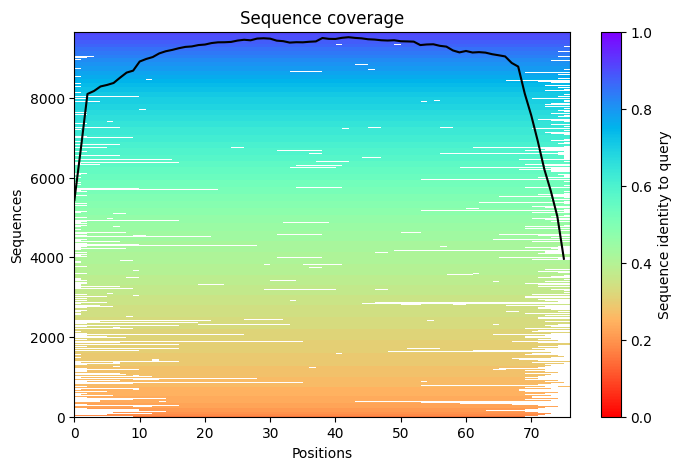

2024-04-25 20:01:43,232 Setting max_seq=4, max_extra_seq=8
2024-04-25 20:01:59,812 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=87.1 pTM=0.715
2024-04-25 20:02:00,559 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=86.9 pTM=0.71 tol=0.646
2024-04-25 20:02:00,560 alphafold2_ptm_model_1_seed_000 took 10.9s (1 recycles)
2024-04-25 20:02:01,328 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=87 pTM=0.716
2024-04-25 20:02:02,077 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=89.4 pTM=0.753 tol=0.409
2024-04-25 20:02:02,079 alphafold2_ptm_model_2_seed_000 took 1.5s (1 recycles)
2024-04-25 20:02:02,847 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=71.2 pTM=0.536
2024-04-25 20:02:03,596 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=85 pTM=0.686 tol=1.13
2024-04-25 20:02:03,598 alphafold2_ptm_model_3_seed_000 took 1.5s (1 recycles)
2024-04-25 20:02:04,366 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=67.1 pTM=0.565
2024-04-25 20:02:05,113 alphafold2_ptm_model_4_seed_000 recycle=1 pLDD

In [ ]:
#@title Run Prediction
display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

def input_features_callback(input_features):
  plot_msa_v2(input_features)
  plt.show()
  plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if False:
    fig = plot_protein(protein_obj, Ls=length, dpi=150)
    plt.show()
    plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True
num_relax=0
download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)


## save the results
os.chdir('/content/colabfold/')
if not os.path.isdir('/content/structures'):
  os.mkdir('/content/structures')
else:
  print('Already exists!!!')
  os.system('mv /content/structures /content/backup')
  os.mkdir('/content/structures')

for i in range(num_seeds*5):
  tag = results["rank"][0][i]
  jobname_prefix = ".custom" if msa_mode == "custom" else ""
  pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
  json_filename = f"{jobname}/{jobname}{jobname_prefix}_scores_{tag}.json"
  os.system(f'cp {pdb_filename} /content/structures/pred_{i+1}.pdb')
  os.system(f'cp {json_filename} /content/structures/pred_{i+1}.json')
os.system(f'cp {jobname}/config.json /content/structures/.')
os.system(f'cp {jobname}/{jobname}.a3m /content/structures/msa.a3m')
os.system(f'rm -r {jobname}')
os.chdir('/content/')
os.system('zip -r structures.zip structures')

print('All structures are saved in `/content/structures.zip`')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

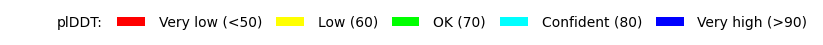

In [ ]:
#@title Display 3D structure (unrelaxed) {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 20 #@param {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

pdb_filename = f"/content/structures/pred_{rank_num}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()